In [71]:
from ultralytics import YOLO
import torch
from PIL import Image
import pandas as pd
from pathlib import Path
from PIL import Image
import os
from collections import Counter

model = YOLO('yolov8m.pt')  # pretrained YOLOv8n model

100%|██████████████████████████████████████| 49.7M/49.7M [00:04<00:00, 12.7MB/s]


In [72]:
def map_year_to_decade(year):
    return (year // 10) * 10

def rename_image(image_name):
    if ".png" not in image_name:
        return f"{image_name}.png"
    else:
        return image_name
    
df = pd.read_csv(f'input/merged_dataset/merged_stats.csv', header=0)

df['decade'] = df['m_year'].apply(map_year_to_decade)
df = df[df['decade'] > 1960]
df['decade'] = df['decade'].replace(2010, 2000)
df = df[df['genres_list'] < 5]
df['m_name_image'] = df['m_name_image'].apply(rename_image)


In [296]:
def mark_row_for_low_resolution(image_name):
    
    images_path = "input/merged_dataset/images_merged"
    file_path = f"{images_path}/{image_name}"

    try:
        # Open the image and get its dimensions
        with Image.open(file_path) as img:
            width, height = img.size
            # Add the dimensions to the set
            dimensions.append((width, height))
            dpi = img.info.get('dpi', None)
            if dpi:
                if dpi[0] < 60 or  dpi[1] < 60:
                    return 0
                else:
                    return 1
            else:
                return -1
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return -2

def get_resolution(image_name):
    
    images_path = "input/merged_dataset/images_merged"
    file_path = f"{images_path}/{image_name}"

    try:
        # Open the image and get its dimensions
        with Image.open(file_path) as img:
            width, height = img.size
            # Add the dimensions to the set
            dimensions.append((width, height))
            dpi = img.info.get('dpi', None)
            if dpi:
                return dpi
            else:
                return -1
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return -2

def mark_row_for_low_dimension(image_name):
    
    images_path = "input/merged_dataset/images_merged"
    file_path = f"{images_path}/{image_name}"

    try:
        # Open the image and get its dimensions
        with Image.open(file_path) as img:
            width, height = img.size
            # Add the dimensions to the set
            if width < 100 or height < 100:
                return 0
            else:
                return 1
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return -2

def get_image_dimension(image_name):
    
    images_path = "input/merged_dataset/images_merged"
    file_path = f"{images_path}/{image_name}"

    try:
        # Open the image and get its dimensions
        with Image.open(file_path) as img:
            width, height = img.size
            return (width, height)
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return -2

In [213]:
class ObjectDetection:
    def __init__(self):
        self.model= self.load_model()

    def load_model(self):
        model = YOLO("yolov8m.pt")
        return model

    def predict(self, image_name):
        results = self.model(image_name, save=False, imgsz=320, conf=0.4)
        return results

                
    def get_results(self, image_name):
        images_path = "input/merged_dataset/images_merged/"
        local_file_name = f"{images_path}{image_name}"

        #print(local_file_name)
        try:
            results = self.predict(local_file_name)
            
            for result in results:
                boxes = result.boxes.cpu().numpy()
                classes_ids = boxes.cls
                pred = []
                for idx, class_id in enumerate(classes_ids):
                    pred.append({
                        "object_name" : result.names[int(class_id)],
                        "class_id" : class_id,
                        "xywh": boxes.xywh[idx],
                        "confidence" : boxes.conf[idx]
                    })
    
            return {
                   "image_name" : image_name,
                   "number of objects":len(pred),
                    "prediction" : pred
                    }
        except Exception as e:
            return -100


In [301]:

images_path = "input/merged_dataset/images_merged/"
object_detection = ObjectDetection()
#df['prediction_results'] = df['m_name_image'].apply(object_detection.get_results)
df['num_objects'] = df['prediction_results'].apply(lambda x: x['number of objects'])
df['prediction'] = df['prediction_results'].apply(lambda x: x['prediction'])
df['object_names'] = df['prediction_results'].apply(lambda x: [pred['object_name'] for pred in x['prediction']])
df['boxes'] = df['prediction_results'].apply(lambda x: [pred['xywh'] for pred in x['prediction']])
df['confidence'] = df['prediction_results'].apply(lambda x: [pred['confidence'] for pred in x['prediction']])

df['unique_object_names'] = df['object_names'].apply(lambda x: list(set(x)))
df['resolution_row'] = df['m_name_image'].apply(get_resolution)
df['dimension_row'] = df['m_name_image'].apply(get_image_dimension)

In [249]:
object_counts = (
    df['object_names']
    .apply(lambda x: pd.Series(x))  # Expand each list into its own series (wide format)
    .apply(pd.Series.value_counts, axis=1)  # Count occurrences across rows
    .fillna(0)  # Replace NaN with 0 (for objects not present)
    .astype(int)  # Ensure counts are integers
)

# Rename columns to prepend 'object_' to each object name
object_counts.columns = ['object_' + col for col in object_counts.columns]

# Concatenate the original DataFrame with the new object count columns
df_final = pd.concat([df, object_counts], axis=1)



In [303]:
df.to_csv('input/merged_dataset/mergged_object_detection.csv', index=False)
df_final.to_csv('input/merged_dataset/mergged_object_detection_pivoted.csv', index=False)

In [254]:

dimensions = []
resolutions = []
counter = 0

for index, row in df.iterrows():
    image_name = row['m_name_image'].strip()
    images_path = "input/merged_dataset/images_merged"
    file_path = f"{images_path}/{image_name}"

    try:
        # Open the image and get its dimensions
        with Image.open(file_path) as img:
            width, height = img.size
            # Add the dimensions to the set
            dimensions.append((width, height))
            dpi = img.info.get('dpi', None)
            if dpi:
                resolutions.append(dpi)
            counter += 1
    except Exception as e:
        print(f"Error processing {filename}: {e}")





In [255]:
tuple_counts = Counter(resolutions)
tuple_dimensions = Counter(dimensions)
print(f"Number of images {counter}")
print(f"Number of images with available resolution defined {len(resolutions)}")


Number of images 20205
Number of images with available resolution defined 12413


In [256]:
dimensions_data = [(k[0], k[1], v) for k, v in tuple_dimensions.items()]
dimensions_df = pd.DataFrame(dimensions_data, columns=['x', 'y', 'count'])
dimensions_df = dimensions_df.sort_values('count', ascending=False)
dimensions_df['Percentage'] = round((dimensions_df['count'] * 100) / len(dimensions), 3)

In [257]:
dimensions_df

x    y  count  Percentage
1    200  200  12487      61.802
2    300  300   3420      16.927
0    300  299    595       2.945
13   300  298    364       1.802
5    130  130    307       1.519
..   ...  ...    ...         ...
187  251  300      1       0.005
189  175  172      1       0.005
190  260  300      1       0.005
191  130  124      1       0.005
317  251  250      1       0.005

[318 rows x 4 columns]

In [258]:
resolutions_data = [(k[0], k[1], v) for k, v in tuple_counts.items()]
resolution_df = pd.DataFrame(resolutions_data, columns=['x', 'y', 'count'])
resolution_df = resolution_df.sort_values('count', ascending=False)
resolution_df['Percentage'] = round((resolution_df['count'] * 100) / len(resolutions), 3)
resolution_df

x     y  count  Percentage
1    300   300   5937      47.829
2     72    72   4887      39.370
0     96    96   1414      11.391
3    200   200     50       0.403
9    100   100     46       0.371
12   150   150     17       0.137
15   600   600      9       0.073
8      6     6      6       0.048
13   400   400      6       0.048
18   762   762      5       0.040
14   304   304      4       0.032
20   180   180      4       0.032
24   299   299      3       0.024
29   157   157      2       0.016
11  1200  1200      2       0.016
7   5000  5000      2       0.016
21    97    97      2       0.016
27   330   330      1       0.008
26   120   120      1       0.008
30    82    82      1       0.008
32   360   360      1       0.008
28   760   760      1       0.008
31    44    44      1       0.008
25   298   298      1       0.008
17   250   250      1       0.008
23     3     3      1       0.008
22   199   199      1       0.008
19   240   240      1       0.008
16    50    50      1       0.008
10   303   303      1       0.008
6     93    93      1       0.008
5    838   838      1       0.008
4    357   357      1       0.008
33   110   110      1       0.008

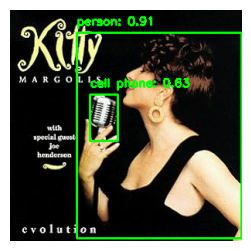

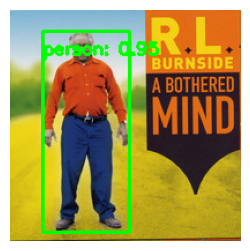

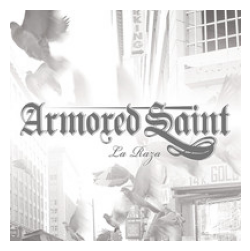

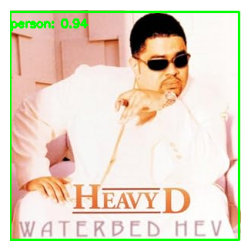

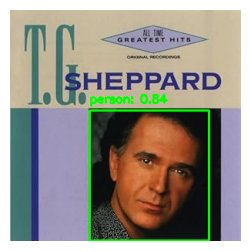

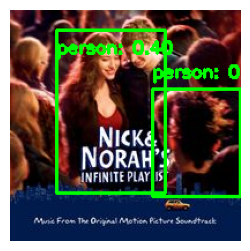

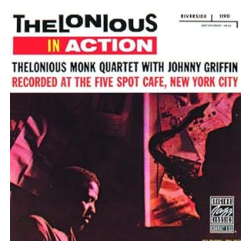

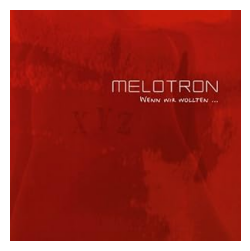

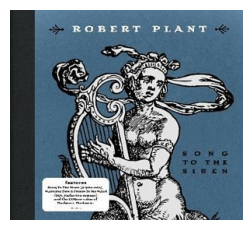

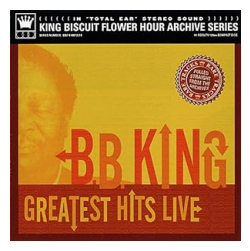

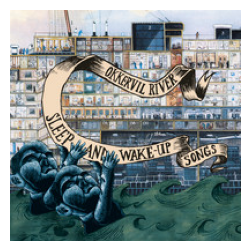

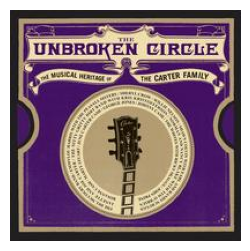

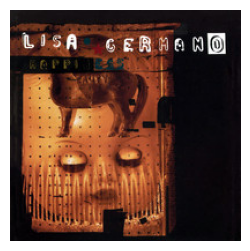

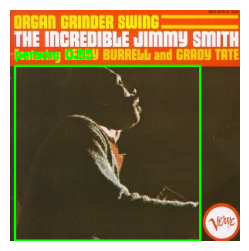

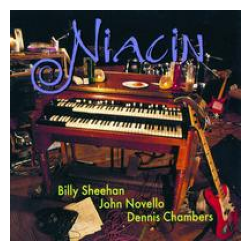

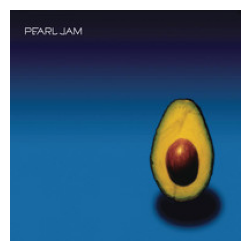

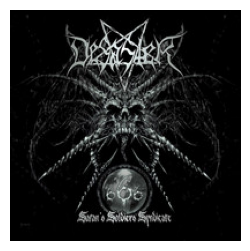

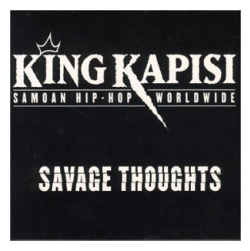

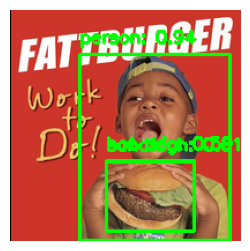

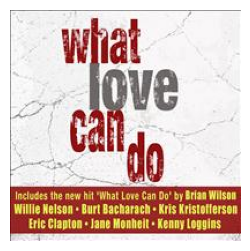

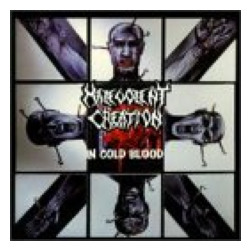

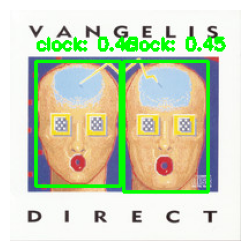

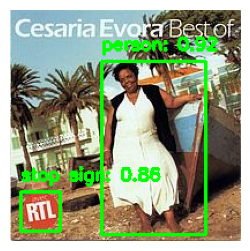

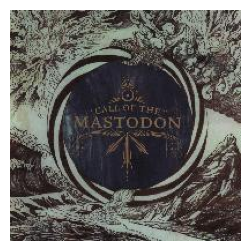

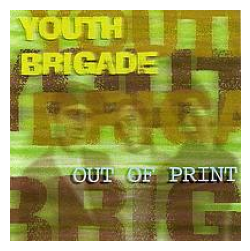

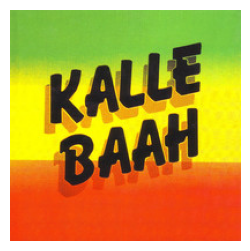

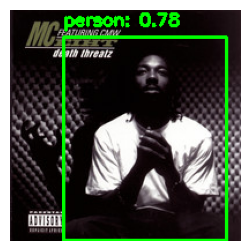

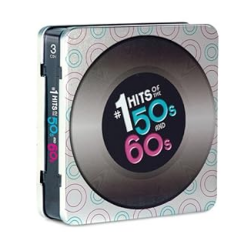

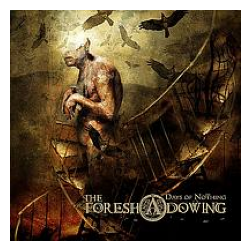

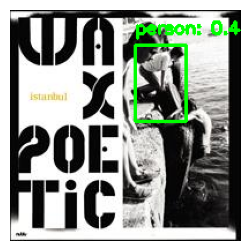

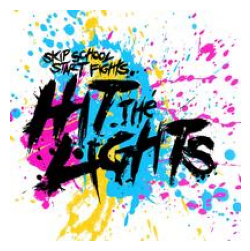

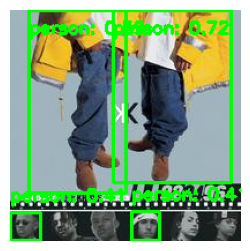

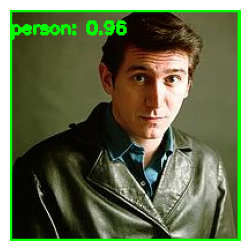

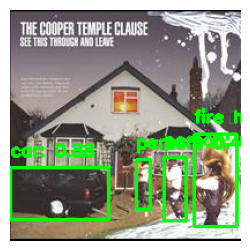

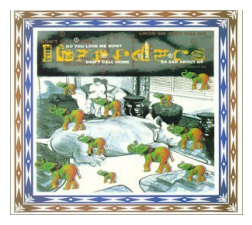

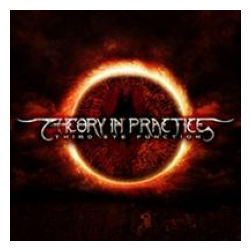

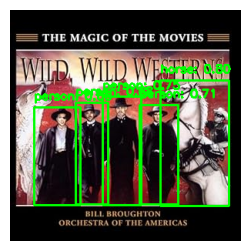

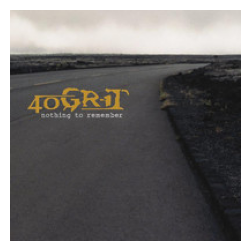

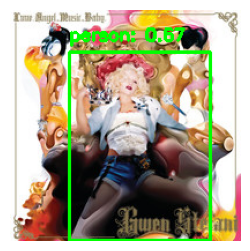

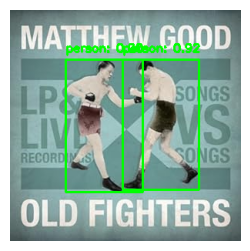

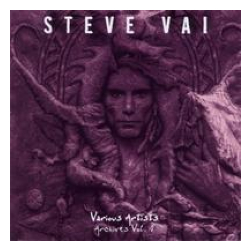

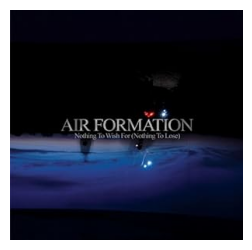

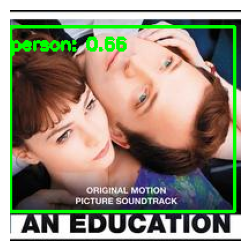

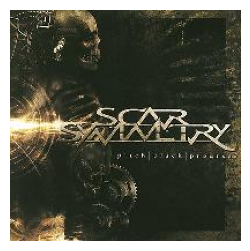

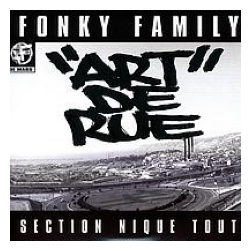

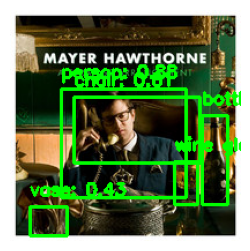

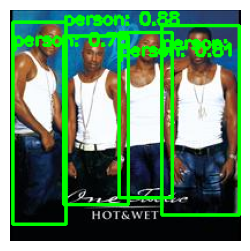

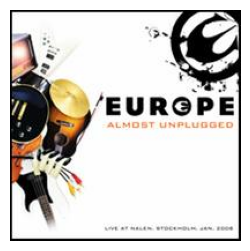

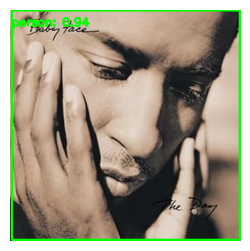

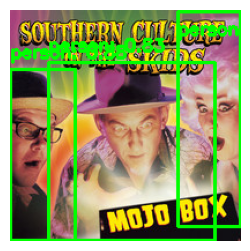

In [318]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import cv2

images_path = "input/merged_dataset/images_merged"
def xywh_to_xyxy(x_center, y_center, width, height):
    x_top_left = int(x_center - (width / 2))
    y_top_left = int(y_center - (height / 2))
    x_bottom_right = int(x_center + (width / 2))
    y_bottom_right = int(y_center + (height / 2))
    return x_top_left, y_top_left, x_bottom_right, y_bottom_right

def display_image_with_boxes_inline(row):
    # Load the image
    image_path = f"{images_path}/{row['image_name']}"
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Iterate over the predictions in the row and draw bounding boxes
    for pred in row['prediction']:
        x_center, y_center, w, h = pred['xywh']
        x_top_left, y_top_left, x_bottom_right, y_bottom_right = xywh_to_xyxy(x_center, y_center, w, h)

        label = pred['object_name']
        confidence = pred['confidence']
        label_with_conf = f'{label}: {confidence:.2f}'

        # Draw rectangle on image
        cv2.rectangle(img, (x_top_left, y_top_left), (x_bottom_right, y_bottom_right), (0, 255, 0), 2)
        
        # Put label with confidence near the bounding box
        text_x = x_top_left
        text_y = y_top_left - 10 if y_top_left - 10 > 10 else y_top_left + 20  # Adjust text position if too close to top
        cv2.putText(img, label_with_conf, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the image using Matplotlib
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis('off')  # Hide the axes
    plt.show()


df['image_name'] = df['prediction_results'].apply(lambda x: x['image_name'])
df['number_of_objects'] = df['prediction_results'].apply(lambda x: x['number of objects'])
df['prediction'] = df['prediction_results'].apply(lambda x: x['prediction'])

# Display the first 10 images with bounding boxes
for index, row in df.head(50).iterrows():
    display_image_with_boxes_inline(row)


In [319]:
def save_image_with_boxes(row, save_path):
    # Load the image
    image_path = f"{images_path}/{row['image_name']}"
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Iterate over the predictions in the row and draw bounding boxes
    for pred in row['prediction']:
        x_center, y_center, w, h = pred['xywh']
        x_top_left, y_top_left, x_bottom_right, y_bottom_right = xywh_to_xyxy(x_center, y_center, w, h)

        label = pred['object_name']
        confidence = pred['confidence']
        label_with_conf = f'{label}: {confidence:.2f}'

        # Draw rectangle on image
        cv2.rectangle(img, (x_top_left, y_top_left), (x_bottom_right, y_bottom_right), (0, 255, 0), 2)
        
        # Put label with confidence near the bounding box
        text_x = x_top_left
        text_y = y_top_left - 10 if y_top_left - 10 > 10 else y_top_left + 20  # Adjust text position if too close to top
        cv2.putText(img, label_with_conf, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Convert the image from RGB back to BGR before saving with OpenCV
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(save_path, img_bgr)

# Set the directory where you want to save the images
save_directory = "saved_images"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Save the first 10 images with bounding boxes
for index, row in df.head(50).iterrows():
    save_image_name = os.path.join(save_directory, os.path.basename(row['image_name']))
    save_image_with_boxes(row, save_image_name)
